# Base text classification

In [63]:
# Version 1
# original: https://www.tensorflow.org/tutorials/keras/text_classification
# 

## Imports

In [64]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tarfile

In [65]:
import tensorflow as tf
print("tf_version=" + tf.__version__)

tf_version=2.3.1


In [66]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [67]:
# uncomment next 2 lines to start on GPU
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Get data

In [68]:
ds_tar = "aclImdb_v1.tar.gz"
ds_tar_filename = os.path.join(os.getcwd(), ds_tar)
ds_folder = os.path.join(os.getcwd(), "aclImdb")
url = f"https://ai.stanford.edu/~amaas/data/sentiment/{ds_tar}"

if not os.path.exists(ds_tar_filename):
    print(f"Get {ds_tar} from {url}...")
    dataset = tf.keras.utils.get_file(ds_tar_filename, 
                                      url,
                                      untar=True,
                                      cache_dir='.',
                                      cache_subdir='')
else:
    dataset = ds_folder
    if not os.path.exists(ds_folder):
        with tarfile.open(ds_tar_filename) as t:
            print(f"Extract from {ds_tar_filename}")
            t.extractall()

print(f"Dataset: {dataset}")

Dataset: C:\Users\dimish\Desktop\neural\aclImdb


In [69]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
print(os.listdir(dataset_dir))
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']
['labeledBow.feat', 'neg', 'pos', 'unsupBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']


In [70]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [71]:
# remove unused folder
remove_dir = os.path.join(train_dir, 'unsup')
if os.path.exists(remove_dir):
    shutil.rmtree(remove_dir)

## Preprocessing

### Make train, validation and test datasets

In [72]:
# prepare raw data, here train dataset separated 80/20 with validation ds
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
# prewiew for raw
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])    

In [74]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


### Prepare dataset to train

#### Standartization

In [75]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, 
                                           '<br />', 
                                           ' ')
    
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [76]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [77]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

#### Vectorization

In [78]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)

  return vectorize_layer(text), label

In [79]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]

In [ ]:
# review for prepared text and vector
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))
print("\n1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

In [81]:
# prepare: text to vectors
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Model

In [82]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Training

In [ ]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

## Evaluate

In [85]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 15s 19ms/step - loss: 0.3121 - binary_accuracy: 0.8736
Loss:  0.31214118003845215
Accuracy:  0.8736400008201599


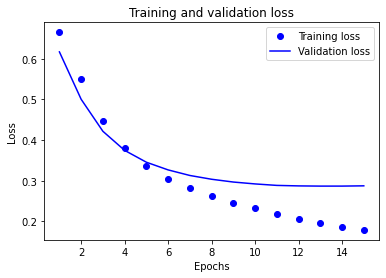

In [86]:
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

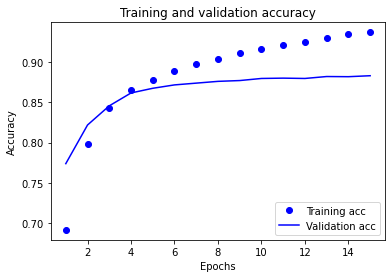

In [87]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Test

In [105]:
# test on any raw data
def test_raw_data(test_model):
    examples = [
        "The movie was great!",
        "The movie was okay.",
        "The movie was terrible...",
        "Loosers cinema",
        "Very good emotions",
        "Movie zero"
        
    ]
    predict = test_model.predict(examples)
    print("Test exapmples:")
    for i in range(len(examples)):
        print(f"{examples[i]}\n\t-> {predict[i]}")

## Export

In [89]:
# export to work not prepared data
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(f"Accuracy: {accuracy}")

782/782 [==============================] - 15s 20ms/step - loss: 0.3121 - accuracy: 0.8736
Accuracy: 0.8736400008201599


In [106]:
print(f"--- Test export model ---")
test_raw_data(export_model)

--- Test export model ---
Test exapmples:
The movie was great!
	-> [0.6186762]
The movie was okay.
	-> [0.39808297]
The movie was terrible...
	-> [0.30441684]
Loosers cinema
	-> [0.5335166]
Very good emotions
	-> [0.66617554]
Movie zero
	-> [0.46859637]


### Save model

In [91]:
# run second cell abowe and this cell before save or load
text_model_folder = os.path.join(os.getcwd(), "training_text_model")
filepath = os.path.join(text_model_folder, f"text_base_ex_{int(accuracy*10000)}")
print(filepath)

C:\Users\dimish\Desktop\neural\training_text_model\text_base_ex_8736


In [92]:
if not os.path.exists(text_model_folder):
    os.mkdir(text_model_folder)

export_model.save(filepath)

INFO:tensorflow:Assets written to: C:\Users\dimish\Desktop\neural\training_text_model\text_base_ex_8736\assets


### Load and test saved model

In [93]:
# warning! you need run cell with custom_standardization fn before
# if you only load model
with tf.keras.utils.custom_object_scope(
    {'custom_standardization': custom_standardization}
):
    load_model = tf.keras.models.load_model(filepath)

In [ ]:
print(f"--- Test loaded model ---")
test_raw_data(load_model)